In [30]:
%load_ext autoreload
%autoreload 2

from msr.training.data.datasets import PtbXLDataset
from msr.training.data.datamodules import PtbXLDataModule
from msr.training.trainers import MLClassifierTrainer
from msr.data.raw.ptbxl import FS
from msr.evaluation.plotters import MatplotlibPlotter, PlotlyPlotter
from msr.evaluation.visualisations import matplotlib_preds_vs_target

TARGET = "diagnostic_class"
BASE_PARAMS = dict(fs=FS, target=TARGET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


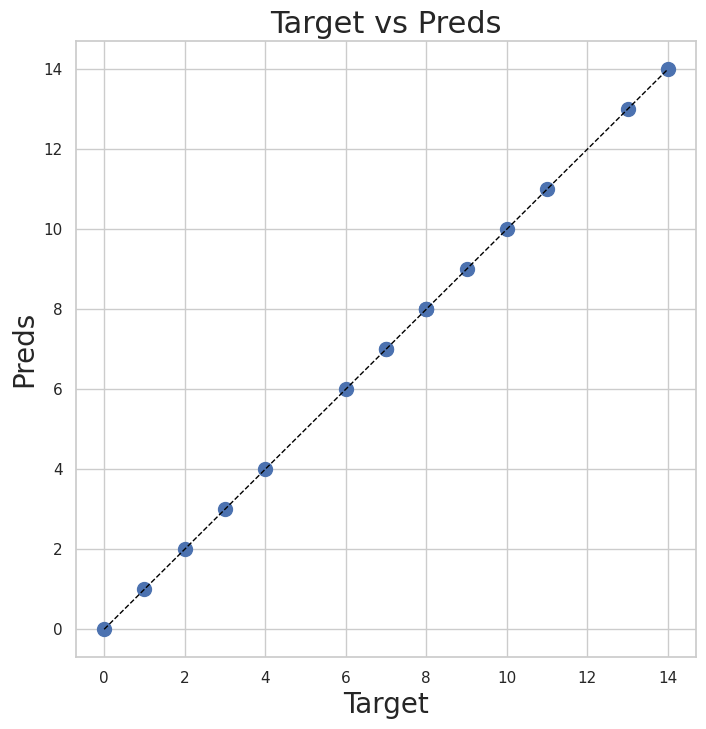

In [38]:
import numpy as np

target = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
preds = np.random.randint(0, 15, 16)

matplotlib_preds_vs_target(preds, preds)

In [20]:
rep_type = "whole_signal_features"
dm = PtbXLDataModule(rep_type, **BASE_PARAMS)
dm.setup()

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=20)
ml_trainer = MLClassifierTrainer(model, dm)
ml_trainer.fit()

/home/shate/.cache/pypoetry/virtualenvs/msr-xbuxOujG-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/home/shate/.cache/pypoetry/virtualenvs/msr-xbuxOujG-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/home/shate/.cache/pypoetry/virtualenvs/msr-xbuxOujG-py3.8/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



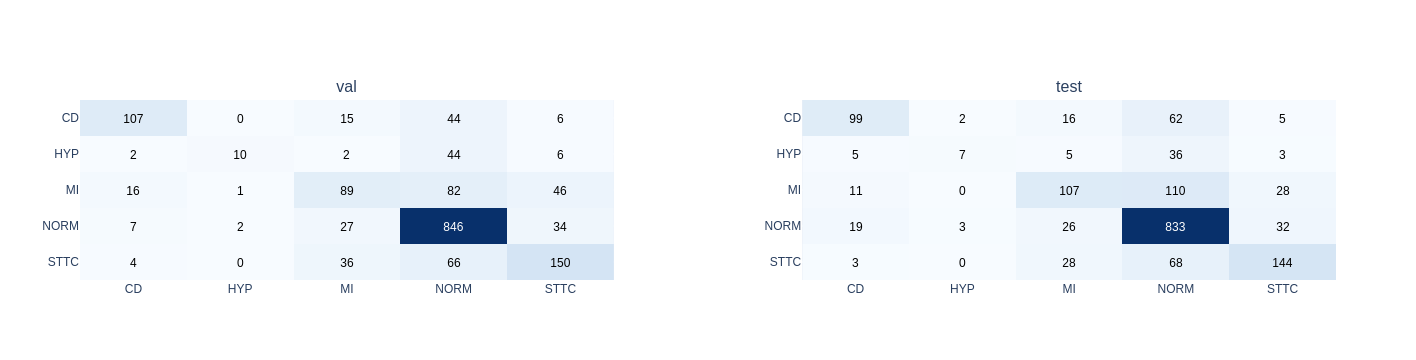

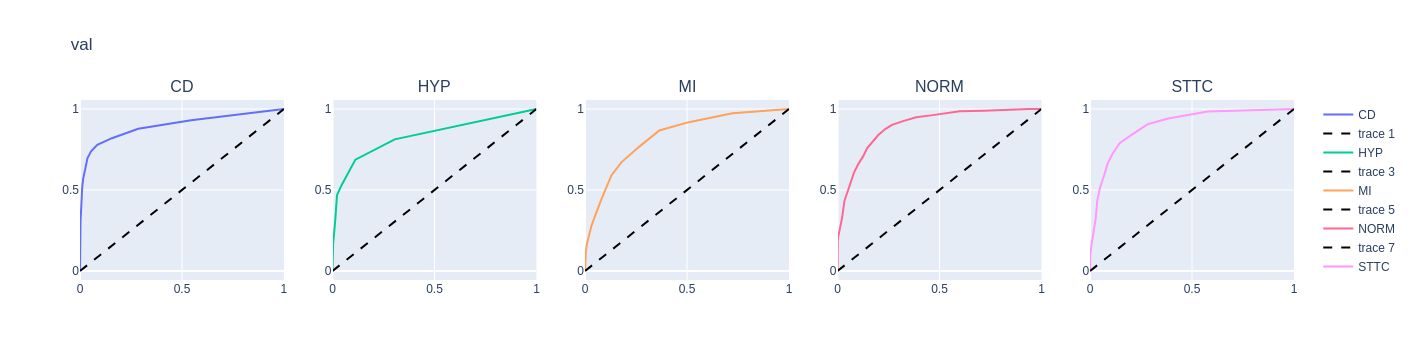

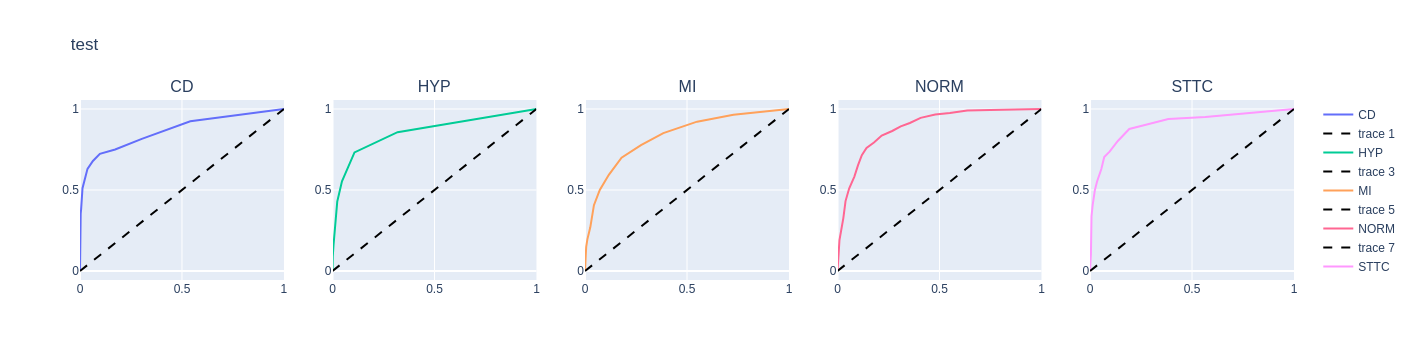

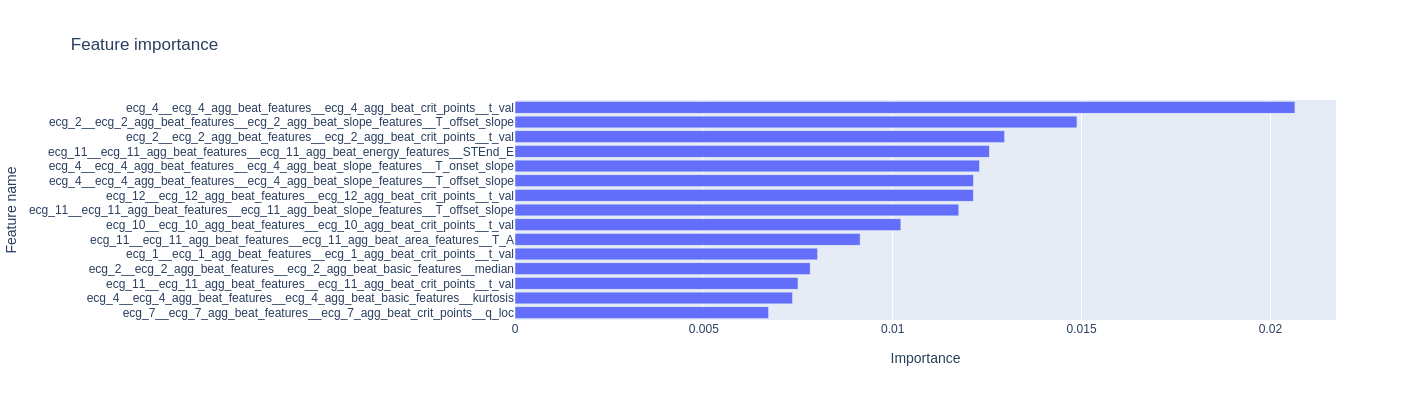

In [22]:
metrics = ml_trainer.evaluate(plotter=plotter)